In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load dataset
data = pd.read_csv("climate_nasa.csv")
print(" Dataset Loaded Successfully!")
print(data.shape)
data.head()

 Dataset Loaded Successfully!
(522, 5)


,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [5]:
# Standardize column names 
data.columns = data.columns.str.strip().str.lower()

print("Columns:", data.columns.tolist())
print("\nMissing values per column:")
print(data.isnull().sum())

# Drop missing text rows
data.dropna(subset=['text'], inplace=True)


Columns: ['date', 'likescount', 'profilename', 'commentscount', 'text']

Missing values per column:
date               0
likescount         0
profilename        0
commentscount    278
text              18
dtype: int64


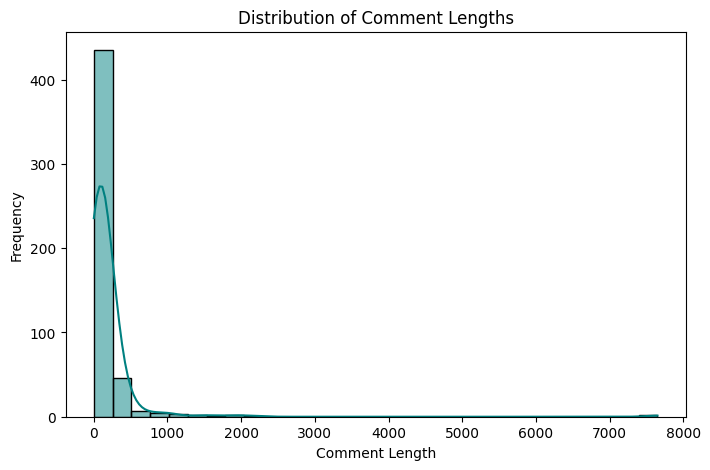

In [6]:
# explore comment lengths
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(data['text_length'], bins=30, kde=True, color='teal')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.show()


Defaulting to user installation because normal site-packages is not writeable
sentiment
Neutral     207
Positive    206
Negative     91
Name: count, dtype: int64


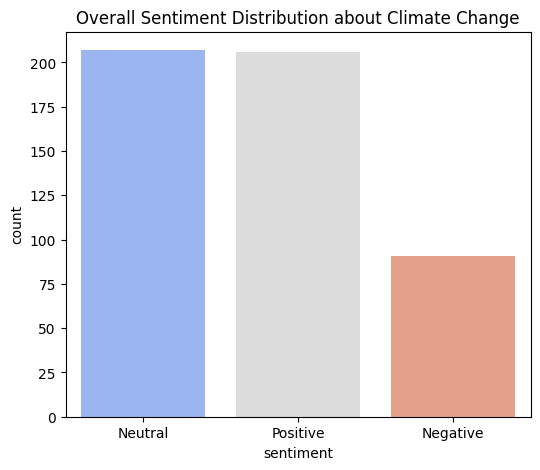

In [7]:
# Sentiment labeling using textblob
!pip install textblob
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment'] = data['text'].apply(get_sentiment)

# Check sentiment distribution
print(data['sentiment'].value_counts())

plt.figure(figsize=(6,5))
sns.countplot(x='sentiment', data=data, palette='coolwarm')
plt.title("Overall Sentiment Distribution about Climate Change")
plt.show()


In [8]:
# clean the text
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)          
    text = re.sub(r"[^a-z\s]", "", text)         
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

data['clean_text'] = data['text'].apply(clean_text)
data.head()


,date,likescount,profilename,commentscount,text,text_length,sentiment,clean_text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...,173,Neutral,neat comparison i have not heard it before\n i...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...,51,Positive,an excellent way to visualise the invisible th...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...,108,Neutral,does the coghg in the troposphere affect the s...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...,94,Positive,excellent post i defo feel the difference one...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart...",128,Negative,yes and carbon dioxide does not harm the earth...


In [9]:
# tf-idf vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data['clean_text'])
y = data['sentiment']


In [10]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Train Logistic Regression Model
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


 Model Evaluation
Accuracy: 0.6138613861386139

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.05      0.10        20
     Neutral       0.65      0.74      0.69        46
    Positive       0.56      0.77      0.65        35

    accuracy                           0.61       101
   macro avg       0.74      0.52      0.48       101
weighted avg       0.69      0.61      0.56       101



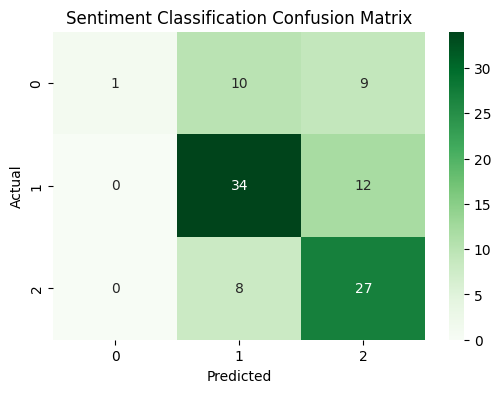

In [12]:
# evaluate the model
print(" Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Sentiment Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
# Predict Sentiment for New Comments
sample_comments = [
    "Climate change is the biggest challenge humanity faces!",
    "I don't believe this climate change stuff at all.",
    "NASA is doing a great job spreading awareness."
]

sample_vec = vectorizer.transform(sample_comments)
predictions = model.predict(sample_vec)

for comment, sentiment in zip(sample_comments, predictions):
    print(f"💬 '{comment}' → Sentiment: {sentiment}")


💬 'Climate change is the biggest challenge humanity faces!' → Sentiment: Positive
💬 'I don't believe this climate change stuff at all.' → Sentiment: Positive
💬 'NASA is doing a great job spreading awareness.' → Sentiment: Positive


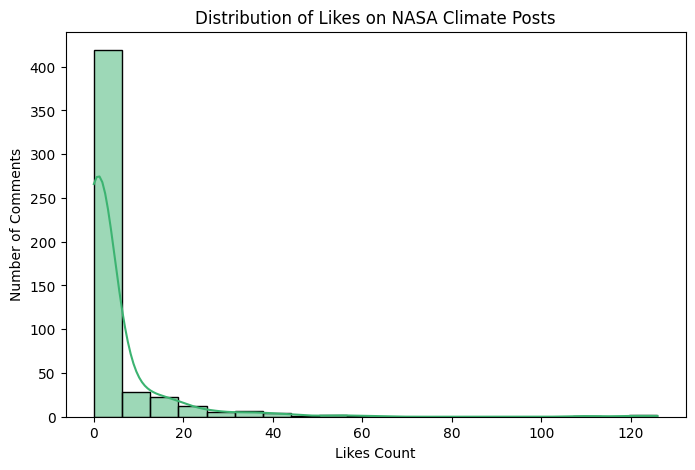

In [16]:
# distribution of likes count
plt.figure(figsize=(8,5))
sns.histplot(data['likescount'], kde=True, color='mediumseagreen', bins=20)
plt.title("Distribution of Likes on NASA Climate Posts")
plt.xlabel("Likes Count")
plt.ylabel("Number of Comments")
plt.show()


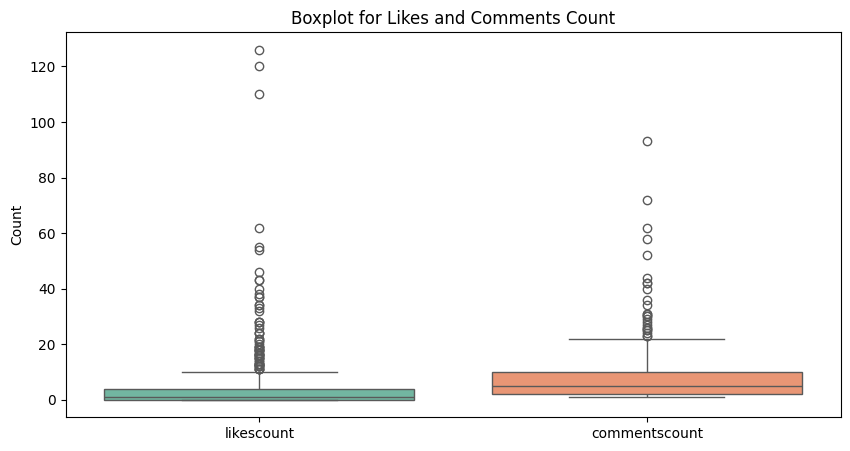

In [17]:
# box plot
# Detect Outliers in Likes and Comments
plt.figure(figsize=(10,5))
sns.boxplot(data=data[['likescount', 'commentscount']], palette='Set2')
plt.title("Boxplot for Likes and Comments Count")
plt.ylabel("Count")
plt.show()
 

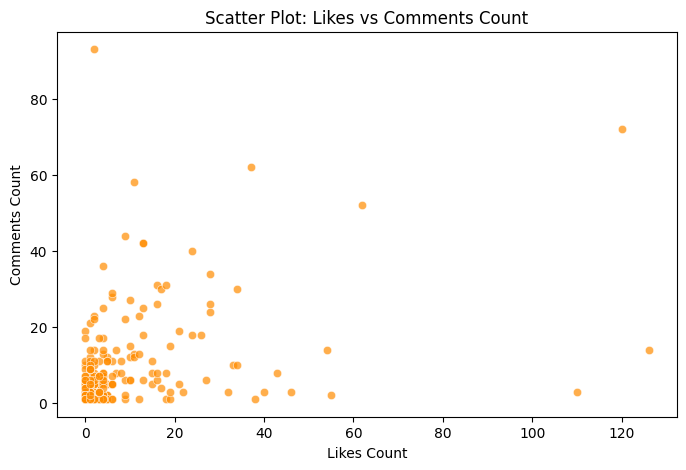

In [18]:
# scatter plot
# Relationship Between Likes and Comments
plt.figure(figsize=(8,5))
sns.scatterplot(x='likescount', y='commentscount', data=data, color='darkorange', alpha=0.7)
plt.title("Scatter Plot: Likes vs Comments Count")
plt.xlabel("Likes Count")
plt.ylabel("Comments Count")
plt.show()


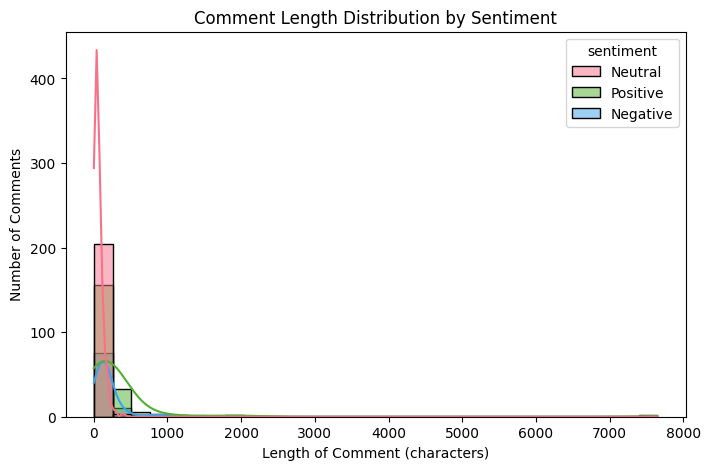

In [19]:
# histogram
# Comment Length Distribution by Sentiment
plt.figure(figsize=(8,5))
sns.histplot(data, x='text_length', hue='sentiment', bins=30, kde=True, palette='husl')
plt.title("Comment Length Distribution by Sentiment")
plt.xlabel("Length of Comment (characters)")
plt.ylabel("Number of Comments")
plt.show()


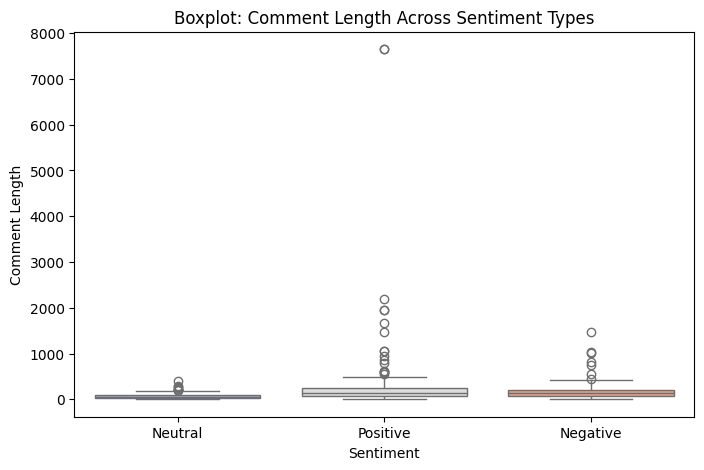

In [20]:
# box plot
# Comment Length by Sentiment
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='text_length', data=data, palette='coolwarm')
plt.title("Boxplot: Comment Length Across Sentiment Types")
plt.xlabel("Sentiment")
plt.ylabel("Comment Length")
plt.show()


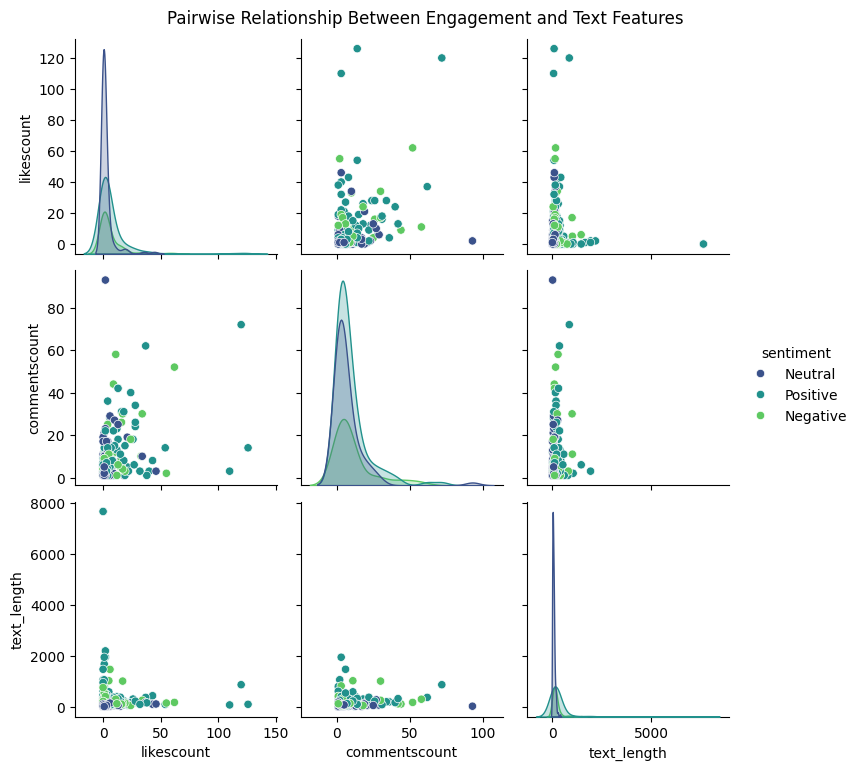

In [21]:
# pairplot
sns.pairplot(data[['likescount', 'commentscount', 'text_length', 'sentiment']], hue='sentiment', palette='viridis')
plt.suptitle("Pairwise Relationship Between Engagement and Text Features", y=1.02)
plt.show()


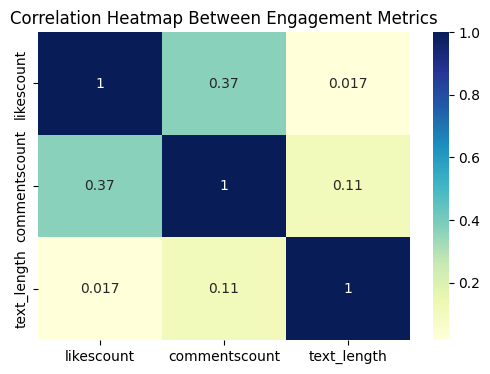

In [22]:
# correlation heatmap
plt.figure(figsize=(6,4))
corr = data[['likescount', 'commentscount', 'text_length']].corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap Between Engagement Metrics")
plt.show()


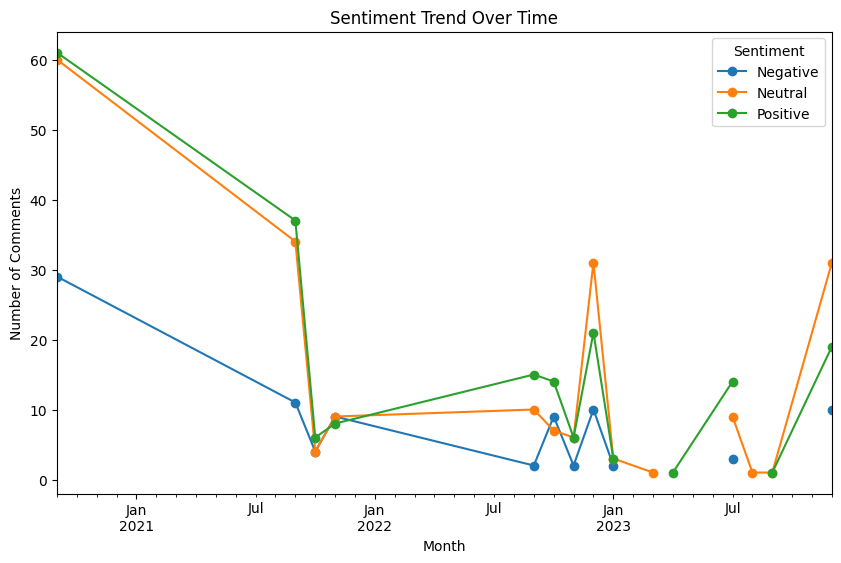

In [23]:
# Convert to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Group by month and count sentiments
monthly_sentiment = data.groupby([data['date'].dt.to_period('M'), 'sentiment']).size().unstack()

# Plot
monthly_sentiment.plot(kind='line', figsize=(10,6), marker='o')
plt.title("Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.legend(title="Sentiment")
plt.show()
